# **Mithila ART CLASSIFICATION MODEL**

## Install Necessary Dependencies

In [1]:
# !pip install tensorflow keras numpy matplotlib scikit-learn opencv-python

# !pip install pillow

In [2]:
import os

import shutil

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image

import numpy as np

import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import TensorBoard

import datetime

import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalMaxPooling2D, GlobalAveragePooling2D

from tensorflow.keras.regularizers import l2

from tensorflow.keras.applications import VGG16

from tensorflow.keras.models import Model

In [3]:
image_labels = [
  "Mandala Art",
  "Mithila Painting",
  "Paubha Painting",
  "Thangka Painting"
]


In [4]:
def split_data(source_dir, dest_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):

    # Validate ratios

    if train_ratio + val_ratio + test_ratio != 1.0:

        raise ValueError("Train, validation, and test ratios must sum to 1.")

    

    # Create destination folders

    for split in ['train', 'val', 'test']:

        split_path = os.path.join(dest_dir, split)

        os.makedirs(split_path, exist_ok=True)

    

    # Iterate over each class folder

    for class_name in os.listdir(source_dir):

        class_path = os.path.join(source_dir, class_name)

        if not os.path.isdir(class_path):

            continue

        

        # Get all files in the class folder

        files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

        

        # Split files into train, validation, and test sets

        train_files, temp_files = train_test_split(files, test_size=(1 - train_ratio), random_state=42)

        val_files, test_files = train_test_split(temp_files, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42)

        

        # Copy files to destination directories

        for split, split_files in zip(['train', 'val', 'test'], [train_files, val_files, test_files]):

            split_class_dir = os.path.join(dest_dir, split, class_name)

            os.makedirs(split_class_dir, exist_ok=True)

            for file in split_files:

                shutil.copy(os.path.join(class_path, file), os.path.join(split_class_dir, file))

    

    print("Data successfully split into train, validation, and test sets.")



# Example usage:

source_directory = "/workspaces/machine-learning/projects/folk-art-classification/dataset"

destination_directory = "./data-set"



# split_data(source_directory, destination_directory)

In [5]:
def convert_images_to_jpg(dataset_dir):

    # Supported extensions for conversion (excluding .svg)

    supported_extensions = ['.jpeg', '.png', '.gif', '.webp']



    # Traverse through the dataset directory

    for root, _, files in os.walk(dataset_dir):

        for file in files:

            file_path = os.path.join(root, file)

            file_name, file_ext = os.path.splitext(file)



            # Check if the file is an SVG

            if file_ext.lower() == '.svg':

                try:

                    os.remove(file_path)  # Delete the SVG file

                    print(f"Deleted SVG file: {file_path}")

                except Exception as e:

                    print(f"Error deleting SVG file {file_path}: {e}")

                continue  # Skip further processing for this file

            

            # Process other supported image types

            if file_ext.lower() in supported_extensions or file_ext.lower() == '.jpg':

                try:

                    # Open the image

                    img = Image.open(file_path).convert('RGB')

                    

                    # New file path with the same directory but `.jpg` extension

                    new_file_path = os.path.join(root, f"{file_name}.jpg")

                    

                    # Save the image as `.jpg`

                    img.save(new_file_path, 'JPEG')

                    

                    # Delete the original file only if it's not already `.jpg`

                    if file_ext.lower() != '.jpg':

                        os.remove(file_path)

                    

                    print(f"Converted and replaced: {file_path} -> {new_file_path}")

                except Exception as e:

                    print(f"Error converting {file_path}: {e}")



# Example usage

dataset_directory = "./data-set"

# convert_images_to_jpg(dataset_directory)


In [6]:
img_size = (128, 128)

batch_size = 32

In [7]:
# Paths to dataset directories

train_dir = '/kaggle/input/art-classification-c4-v3/augment-dataset/train'

val_dir = '/kaggle/input/art-classification-c4-v3/augment-dataset/val'

test_dir = '/kaggle/input/art-classification-c4-v3/augment-dataset/test'

In [8]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.5),
    tf.keras.layers.RandomZoom(0.5),
    tf.keras.layers.RandomContrast(0.2),   # Adjust contrast
    tf.keras.layers.RandomTranslation(0.2, 0.2),  # Shift image randomly
])


In [9]:
def preprocess(image, label, augment=False):

    image = tf.image.resize(image, img_size)

    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]

    if augment:

        image = data_augmentation(image)  # Apply data augmentation if specified

    return image, label

In [10]:
def prepare_dataset(directory, augment=False, shuffle=True):

    dataset = tf.keras.utils.image_dataset_from_directory(

        directory,

        labels='inferred',        # Infer labels from subdirectory names

        label_mode='categorical', # One-hot encoded labels

        image_size=img_size,      # Resize images

        batch_size=batch_size,    # Number of images per batch

        shuffle=shuffle           # Shuffle data (disable for test dataset)

    )

    dataset = dataset.map(lambda x, y: preprocess(x, y, augment=augment))  # Apply preprocessing

    return dataset.prefetch(buffer_size=tf.data.AUTOTUNE)  # Prefetch for performance


In [11]:
train_dataset = prepare_dataset(train_dir, augment=True, shuffle=True)  # Augmentation enabled

val_dataset = prepare_dataset(val_dir, augment=False, shuffle=True)    # No augmentation

test_dataset = prepare_dataset(test_dir, augment=False, shuffle=True) 

Found 15498 files belonging to 4 classes.
Found 3164 files belonging to 4 classes.
Found 479 files belonging to 4 classes.


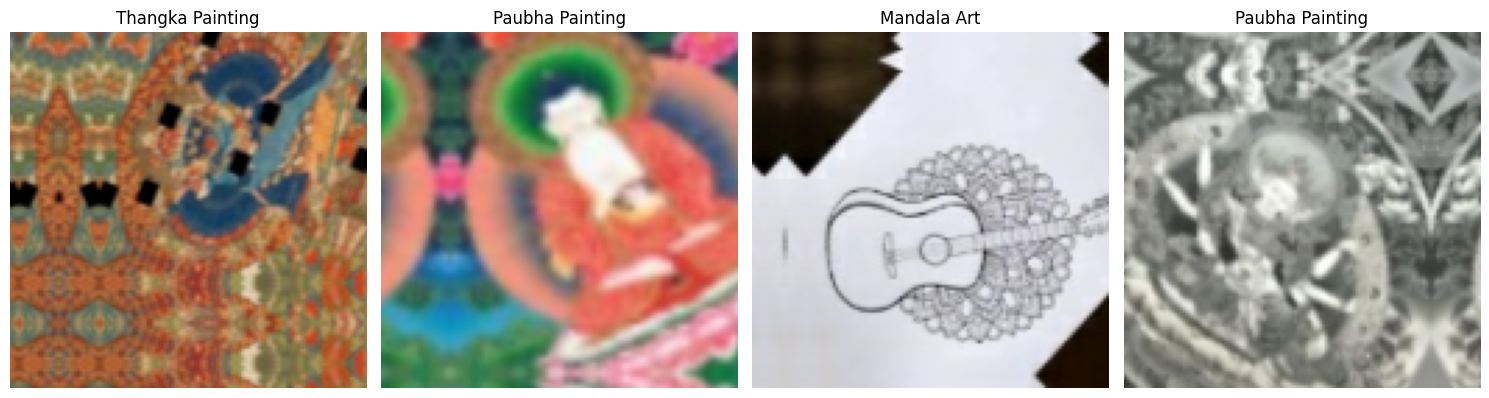

In [12]:
# Fetch a batch of images and labels from the training dataset

images, labels = next(iter(train_dataset))  # `train_dataset` is from the updated pipeline



# Define the number of images to display

num_images = 4

plt.figure(figsize=(15, 10))  # Create a larger figure for better visualization



# Loop through the number of images to display

for index in range(num_images):

    plt.subplot(1, num_images, index + 1)  # Create a subplot for each image

    plt.imshow(images[index].numpy())  # Display the image (convert Tensor to NumPy)

    class_label = labels[index].numpy().argmax()  # Get the class index from one-hot encoding

    class_name = image_labels[class_label]  # Get class name

    plt.title(class_name)  # Set the title to the class name

    plt.axis('off')  # Turn off axis



plt.tight_layout()

plt.show()

In [13]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze pretrained layers

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')  # Adjust for 4 classes
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
# Define the log directory

log_dir = os.path.join("logs", "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))



# Create a TensorBoard callback

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


In [16]:
early_stopping = EarlyStopping(

    monitor='val_loss',        # Metric to monitor (e.g., 'val_loss' or 'val_accuracy')

    patience=4,                # Number of epochs to wait before stopping

    restore_best_weights=True  # Restores the weights of the best epoch

)

In [17]:
for images, labels in train_dataset.take(1):

    print(f"Image batch shape: {images.shape}")

    print(f"Label batch shape: {labels.shape}")


Image batch shape: (32, 128, 128, 3)
Label batch shape: (32, 4)


In [18]:
history = model.fit(

    train_dataset,                # Training dataset

    epochs=30,                    # Adjust epochs as needed

    validation_data=val_dataset,  # Validation dataset

    callbacks=[tensorboard_callback, early_stopping]  # Include callbacks

)

Epoch 1/30


I0000 00:00:1733390240.882015    4771 service.cc:145] XLA service 0x78d17c010550 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733390240.882077    4771 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/485 ━━━━━━━━━━━━━━━━━━━━ 1:10:54 9s/step - accuracy: 0.2812 - loss: 1.4232

I0000 00:00:1733390247.370790    4771 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


485/485 ━━━━━━━━━━━━━━━━━━━━ 110s 210ms/step - accuracy: 0.4925 - loss: 1.1588 - val_accuracy: 0.6299 - val_loss: 0.8844
Epoch 2/30
485/485 ━━━━━━━━━━━━━━━━━━━━ 92s 190ms/step - accuracy: 0.5815 - loss: 0.9345 - val_accuracy: 0.6884 - val_loss: 0.7746
Epoch 3/30
485/485 ━━━━━━━━━━━━━━━━━━━━ 93s 191ms/step - accuracy: 0.6131 - loss: 0.8873 - val_accuracy: 0.6745 - val_loss: 0.7874
Epoch 4/30
485/485 ━━━━━━━━━━━━━━━━━━━━ 93s 191ms/step - accuracy: 0.6241 - loss: 0.8672 - val_accuracy: 0.6757 - val_loss: 0.7847
Epoch 5/30
485/485 ━━━━━━━━━━━━━━━━━━━━ 92s 189ms/step - accuracy: 0.6310 - loss: 0.8540 - val_accuracy: 0.6918 - val_loss: 0.7618
Epoch 6/30
485/485 ━━━━━━━━━━━━━━━━━━━━ 93s 192ms/step - accuracy: 0.6372 - loss: 0.8380 - val_accuracy: 0.6912 - val_loss: 0.7439
Epoch 7/30
485/485 ━━━━━━━━━━━━━━━━━━━━ 93s 192ms/step - accuracy: 0.6375 - loss: 0.8310 - val_accuracy: 0.6865 - val_loss: 0.7764
Epoch 8/30
485/485 ━━━━━━━━━━━━━━━━━━━━ 91s 188ms/step - accuracy: 0.6524 - loss: 0.8116 - va

In [19]:
test_loss, test_acc = model.evaluate(test_dataset)

print(f"Test Accuracy: {test_acc}")


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 254ms/step - accuracy: 0.7013 - loss: 0.7190
Test Accuracy: 0.6826722621917725


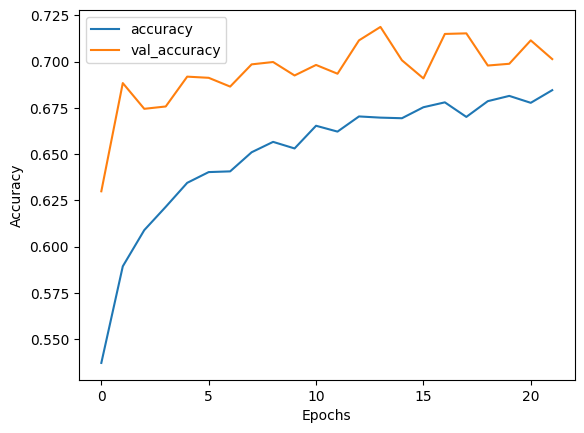

In [20]:
plt.plot(history.history['accuracy'], label='accuracy')

plt.plot(history.history['val_accuracy'], label='val_accuracy')

plt.xlabel('Epochs')

plt.ylabel('Accuracy')

plt.legend()

plt.show()

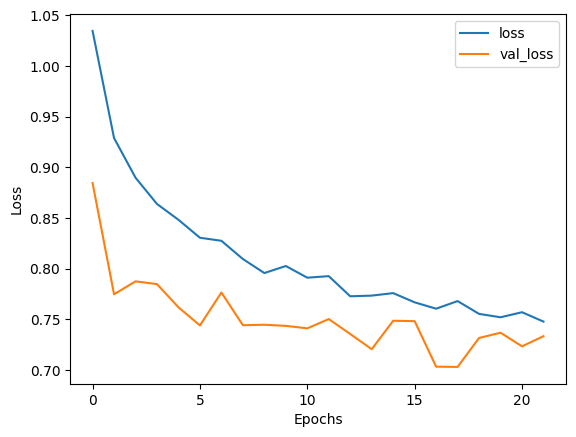

In [21]:
plt.plot(history.history['loss'], label='loss')

plt.plot(history.history['val_loss'], label='val_loss')

plt.xlabel('Epochs')

plt.ylabel('Loss')

plt.legend()

plt.show()

In [22]:
from tensorflow.keras.models import load_model


In [23]:
model.save('art-classification-custom-dataset-c4-v1.h5')

In [24]:
# model = load_model('./model/art-classification-v2.h5')

In [25]:
test_images, test_labels = next(iter(test_dataset))

In [26]:
img_predict = model.predict(test_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


In [27]:
np.argmax(test_labels[0])

0

In [28]:
np.argmax(img_predict[0])

3

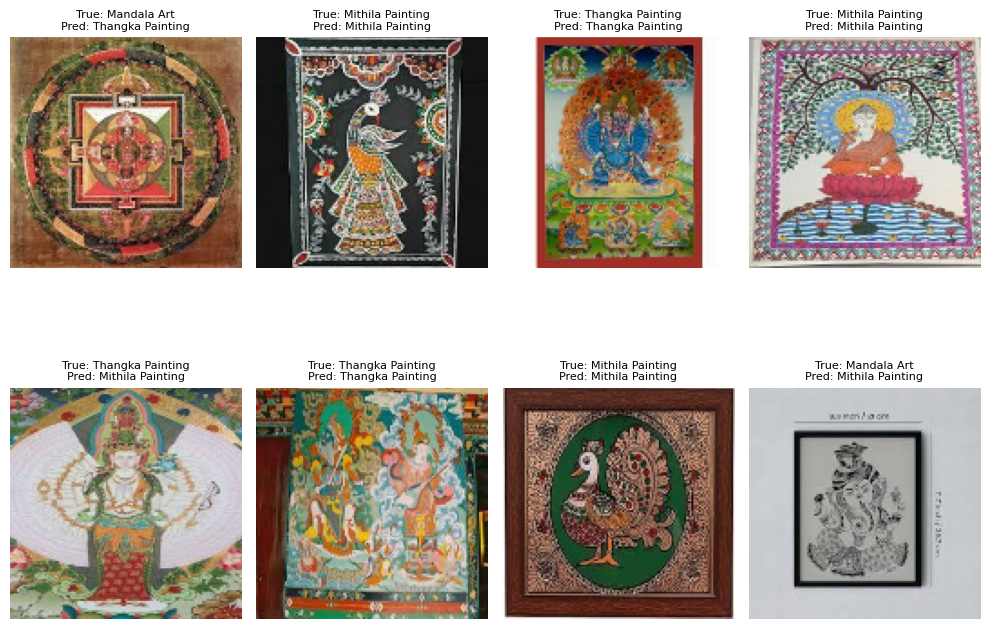

In [29]:
# Plotting

plt.figure(figsize=(10, 8))

for i in range(8):

    plt.subplot(2, 4, i + 1)  # Create a grid of subplots (2 rows, 4 columns)

    plt.imshow(test_images[i], cmap="gray")  # Display the image in grayscale

    

    # Get predicted and true class names

    predicted_class = image_labels[np.argmax(img_predict[i])]

    true_class = image_labels[np.argmax(test_labels[i])]

    

    # Display predicted and true class names

    plt.title(f"True: {true_class}\nPred: {predicted_class}", fontsize=8)

    plt.axis("off")  # Hide axes



plt.tight_layout()

plt.show()
